# How To Use The COSIMA Cookbook

This notebook is designed to help new users get to grips with the COSIMA Cookbook.

It assumes that:
 * You have access to the COSIMA cookbook.
 * We recommend using the latest version of the cookbook available through the `conda/analysis3-unstable` module on NCI.
 * You can fire up a Jupyter notebook!

**Before starting,** load in some standard libraries that you are likely to need:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs

In addition, you **always** need to load the cosima_cookbook module. This provides a bunch of functions that you will use:

In [2]:
import cosima_cookbook as cc

## 1. The Cookbook Philosophy
The COSIMA Cookbook is a framework for analysing ocean-sea ice model output.
It is designed to:
* Provide examples of commonly used diagnostics;
* Write efficient, well-documented, openly accessible code;
* Encourage community input to the code;
* Ensure diagnostic results are reproducible;
* Process diagnostics directly from the model output, minimising creation of intermediate files;
* Find methods to deal with the memory limitations of analysing high-resolution model output.


### 1.1 A database of experiments
The COSIMA Cookbook relies on a database of experiments in order to load model output. This database effectively holds metadata for each experiment, as well as variable names, data ranges and so on. 

There are two different ways for you to access the database:
1. You can use the default database, which is periodically refreshed automatically. This database sits in `/g/data3/hh5/tmp/cosima/database/access-om2.db` and should be readable for all users. It includes all experiments stored in the COSIMA data directory under project `hh5` on NCI. The examples in this tutorial use this database.
2. Otherwise, you can make your own database, which is stored in your own path and includes only the experiments you are interested in. Please refer to the `Make_Your_Own_Database` tutorial for instructions on how to create this database.

To access the default database, you need to start a database session each time you fire up a notebook:

In [3]:
session = cc.database.create_session()

### 1.2 Inbuilt Database Functions

We have constructed a few functions to help you operate the cookbook and to access the datasets. These functions all sit in the `cosima_cookbook` directory. For example, `netcdf_index.py` contains the above `build_index` function as well as a series of functions that are built to query the SQL database.

`get_experiments` lists all of the experiments that are catalogued in the database.

In [4]:
cc.querying.get_experiments(session)

,experiment,ncfiles
0,01deg_jra55v13_ryf8485_spinup6_update_ocn_f,40
1,01deg_jra55v13_ryf8485_spinup6_dt_720,21
2,01deg_jra55v13_ryf8485_spinup6_newexe_highfreq,1222
3,01deg_jra55v13_ryf8485_spinup6_newtopog,225
4,01deg_jra55v13_ryf8485_spinup6_newtopog_scalewind,96
...,...,...
152,monthly,13
153,10,12
154,10_KDS75,12
155,01,12


Internally, an experiment is a set of netCDF4 files as shown in the above table.

`get_ncfiles` provides a list of all the netcdf filenames saved for a given experiment along with the time stamp for when that file was added to the cookbook database. Note that each of these filenames are present in some or all of the output directories -- **but the cookbook philosophy is that you don't need to know about the directories in which these files are stored**. To see the relevant files:

In [5]:
cc.querying.get_ncfiles(session, '025deg_jra55v13_ryf8485_gmredi6')

,ncfile,index_time
0,output000/ice/OUTPUT/iceh.1900-01.nc,2019-06-21 13:22:35.285505
1,output000/ice/OUTPUT/iceh.1900-02.nc,2019-06-21 13:22:33.693859
2,output000/ice/OUTPUT/iceh.1900-03.nc,2019-06-21 13:22:33.462804
3,output000/ice/OUTPUT/iceh.1900-04.nc,2019-06-21 13:22:38.755781
4,output000/ice/OUTPUT/iceh.1900-05.nc,2019-06-21 13:22:34.233748
...,...,...
4975,restart147/ice/mice.nc,2019-06-21 13:16:04.354172
4976,restart147/ice/monthly_sstsss.nc,2019-06-21 13:16:04.278494
4977,restart147/ice/o2i.nc,2019-06-21 13:16:04.205090
4978,restart147/ice/sicemass.nc,2019-06-21 13:16:04.057519


More usefully, `get_variables` provides a list of all the variables available in a specific experiment. 

In [6]:
cc.querying.get_variables(session, experiment='025deg_jra55v13_ryf8485_gmredi6', frequency='1 monthly')

,name,frequency,ncfile,# ncfiles,time_start,time_end
0,ANGLE,1 monthly,output148/ice/OUTPUT/iceh.2197-12.nc,3600,1900-01-01 00:00:00,2198-01-01 00:00:00
1,ANGLET,1 monthly,output148/ice/OUTPUT/iceh.2197-12.nc,3600,1900-01-01 00:00:00,2198-01-01 00:00:00
2,HTE,1 monthly,output148/ice/OUTPUT/iceh.2197-12.nc,3600,1900-01-01 00:00:00,2198-01-01 00:00:00
3,HTN,1 monthly,output148/ice/OUTPUT/iceh.2197-12.nc,3600,1900-01-01 00:00:00,2198-01-01 00:00:00
4,NCAT,1 monthly,output148/ice/OUTPUT/iceh.2197-12.nc,3600,1900-01-01 00:00:00,2198-01-01 00:00:00
...,...,...,...,...,...,...
174,vvel_m,1 monthly,output148/ice/OUTPUT/iceh.2197-12.nc,3600,1900-01-01 00:00:00,2198-01-01 00:00:00
175,xt_ocean,1 monthly,output148/ocean/ocean_snapshot.nc,300,1900-01-01 00:00:00,2198-01-01 00:00:00
176,xu_ocean,1 monthly,output148/ocean/ocean_snapshot.nc,300,1900-01-01 00:00:00,2198-01-01 00:00:00
177,yt_ocean,1 monthly,output148/ocean/ocean_snapshot.nc,300,1900-01-01 00:00:00,2198-01-01 00:00:00


Omitting the `frequency` would give variables at all temporal frequencies.  To determine what frequencies are in a given experient, we can use `get_frequencies`. Leaving off the `experiment` gives all possible frequencies.

In [7]:
cc.querying.get_frequencies(session, experiment='025deg_jra55v13_ryf8485_gmredi6')

,frequency
0,None
1,1 monthly
2,1 yearly
3,static


### 1.3 Loading data from a netcdf file

Python has many ways of reading in data from a netcdf file ... so we thought we would add another way. This is achieved in the `querying.getvar()` function, which is the most commonly used function in the cookbook. This function queries the database to find a specific variable, and loads some or all of that file. We will now take a little while to get to know this function. In it's simplest form, you need just three arguments: expt, variable and database. 

You can see all the available options using the inbuilt help function, which brings up the function documentation.

In [8]:
help(cc.querying.getvar)

Help on function getvar in module cosima_cookbook.querying:

getvar(expt, variable, session, ncfile=None, start_time=None, end_time=None, n=None, **kwargs)
    For a given experiment, return an xarray DataArray containing the
    specified variable.
    
    expt - text string indicating the name of the experiment
    variable - text string indicating the name of the variable to load
    session - a database session created by cc.database.create_session()
    ncfile - may be used if disambiguation based on filename is required
    start_time - only load data after this date. specify as a text string,
                 e.g. '1900-01-01'
    end_time - only load data before this date. specify as a text string,
               e.g. '1900-01-01'
    n - after all other queries, restrict the total number of files to the
        first n. pass a negative value to restrict to the last n
    
    Note that if start_time and/or end_time are used, the time range
    of the resulting dataset may not

You may like to note a few things about this function:
1. The data is returned as an xarray DataArray, which includes the coordinate and attribute information from the netcdf file (more on xarray later). 
2. The variable time does not start at zero - and if you don't like it you can introduce an offset to alter the time axis.
3. By default, we load the whole dataset, but we can load a subset of the times (see below).
4. Other customisable options include setting the variable chunking and incorporating a function to operate on the data.

In [9]:
expt = '025deg_jra55v13_ryf8485_gmredi6'
variable = 'temp_global_ave'
darray = cc.querying.getvar(expt, variable, session)
darray

,Array,Chunk
Bytes,14.30 kB,4 B
Shape,"(3576, 1)","(1, 1)"
Count,7301 Tasks,3576 Chunks
Type,float32,numpy.ndarray


You can see that this operation loads the globally averaged potential temperature  from the model output. The time axis runs from 1900 to 2198. For some variables (particularly 3D variables that might use a lot of memory) you may prefer to restrict yourself to a smaller time window:

In [10]:
darray = cc.querying.getvar(expt,variable,session,
                            start_time='2000-01-01',
                            end_time='2050-12-31')
darray

,Array,Chunk
Bytes,2.59 kB,4 B
Shape,"(648, 1)","(1, 1)"
Count,1323 Tasks,648 Chunks
Type,float32,numpy.ndarray


You will see that the time boundaries are not exact here. `cc.querying.getvar` loads all files that include any dates within the specified range.  You can use `.sel()` to refine this selection if required (see below).

### 1.4 Exercises
OK, this is a tutorial, so now you have to do some work. Your tasks are to:
* Find and load SSH from an experiment (an experiment ... perhaps a 1° configuration would be best).

* Just load the last 10 files from an experiment (any variable you like).

* Load potential temperature from an experiment (again, 1° would be quickest). Can you chunk the data differently from the default?

## 2. How to manipulate and plot variables with xarray
We use the python package `xarray` (which is built on `dask`, `pandas`, `matplotlib` and `numpy`) for many of our diagnostics. `xarray` has a a lot of nice features, some of which we will try to demonstrate for you. 

### 2.1 Plotting
`xarray`'s `.plot()` method does its best to figure out what you are trying to plot, and plotting it for you. Let's start by loading a 1-dimensional variable and plotting.

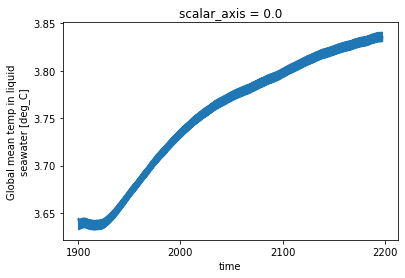

In [11]:
expt = '025deg_jra55v13_ryf8485_gmredi6'
variable = 'temp_global_ave'
darray = cc.querying.getvar(expt, variable, session)
darray.plot()

In [12]:
darray

,Array,Chunk
Bytes,14.30 kB,4 B
Shape,"(3576, 1)","(1, 1)"
Count,7301 Tasks,3576 Chunks
Type,float32,numpy.ndarray


You should see that `xarray` has figured out that this data is a timeseries, that the x-axis is representing time and that the y-axis is `temp_global_ave`. You can always modify aspects of your plot if you are unhappy with the default xarray behaviour:

Text(0.5, 1.0, 'Globally Averaged Temperature')

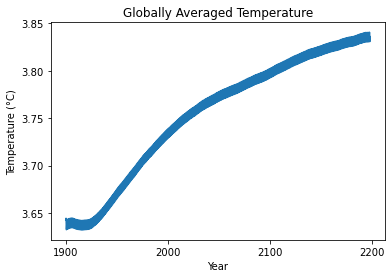

In [13]:
darray.plot()
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Globally Averaged Temperature')

Because `xarray` knows about dimensions, it has plotting routines which can figure out what it should plot. By way of example, let's load a single time slice of `surface_temp` and see how `.plot()` handles it: 

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


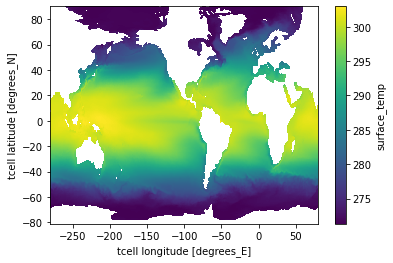

In [14]:
expt = '025deg_jra55v13_ryf8485_gmredi6'
variable = 'surface_temp'
darray = cc.querying.getvar(expt, variable, session, n=-1)
darray.mean('time').plot()

Again, you can customise this plot as you see fit:

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 0, 'longitude')

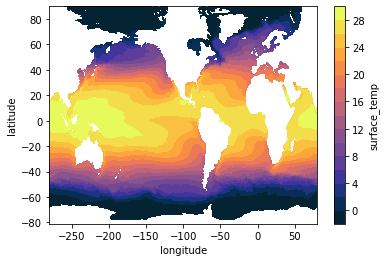

In [15]:
darray = darray - 273.15 # convert from Kelvin to Celsius
darray.mean('time').plot.contourf(levels=np.arange(-2, 32, 2), cmap=cm.cm.thermal)
plt.ylabel('latitude')
plt.xlabel('longitude')

### 2.2 Slicing and dicing

There are two different ways of subselecting from a DataArray: `isel` and `sel`. The first of these is probably what you are used to -- you specify the value of the index of the array. In the second case you specify the value of the coordinate you want to select. These two methods are demonstrated in the following example:

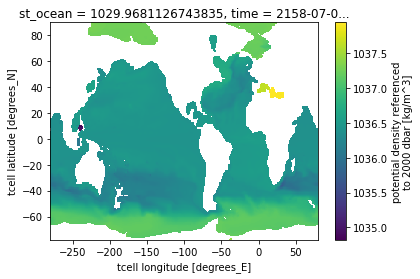

In [16]:
darray = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1','pot_rho_2',session)
density = darray.isel(time=200).sel(st_ocean=1000, method='nearest')
density.plot()

In the above example, a 300-year dataset is loaded. We then use `isel` to select the 201st year (timeindex of 200) and use `sel` to select a z level that is about 1000m deep. The `sel` method is very flexible, allowing us to use similar code in differing model resolutions or grids. In addition, both methods allow you to slice a range of values:

In [18]:
darray = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1', 'v', session)
v = darray.isel(time=100).sel(st_ocean=50, method='nearest').sel(yu_ocean=slice(-50, -20)).sel(xu_ocean=slice(-230, -180)).load()
v.plot()

/home/552/nc3020/.local/lib/python3.7/site-packages/cosima_cookbook/querying.py:190: UserWarning: Your query gets a variable from differently-named files: {'ocean_month.nc', 'ocean_snapshot.nc', 'ocean.nc'}. This could lead to unexpected behaviour! Disambiguate by passing ncfile= to getvar, specifying the desired file.
  f"Your query gets a variable from differently-named files: {unique_files}. "


ValueError: Resulting object does not have monotonic global indexes along dimension time

Here we have taken meridional velocity, and sliced out a small region of interest for our plot. Note the `load()` method, which tells `xarray` to do the calculation (otherwise `xarray` aims to defer calculations until the variable is needed).

### 2.3 Averaging along dimensions

We often perform operations such as averaging on dataarrays. Again, knowledge of the coordinates can be a big help here, as you can instruct the `mean()` method to operate along given coordinates. The case below takes a temporal and zonal average of potential density. (To be precise, it is actually a mean in the i grid direction, which is only zonal outside the tripolar region in the Arctic, i.e. south of 65N in the ACCESS-OM2 models.)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


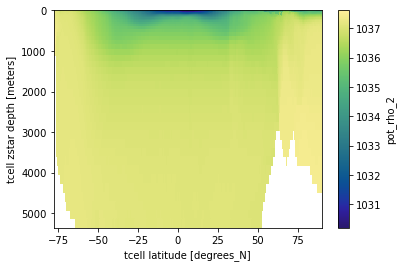

In [19]:
darray = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1', 'pot_rho_2', session, n=-10)
darray.mean('time').mean('xt_ocean').plot(cmap=cm.cm.haline)
plt.gca().invert_yaxis()

### 2.4 Resampling

`xarray` uses `datetime` conventions to allow for operations such as resampling in time. This resampling is simple and powerful. Here is an example of re-plotting the figure from 2.1 with annual averaging:

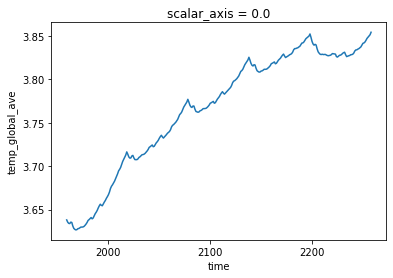

In [21]:
darray = cc.querying.getvar('025deg_jra55v13_iaf_gmredi6', 'temp_global_ave', session)
meandata = darray.resample(time='A').mean(dim='time')
meandata.plot()

### 2.5 Exercises

 * Pick an experiment and plot a map of the temperature of the upper 100m of the ocean for one year.

 * Now, take the same experiment and construct a timeseries of spatially averaged (regional or global) upper 700m temperature, resampled every 3 years.

## 3. More Advanced Stuff

### 3.1 Making a map with cartopy

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


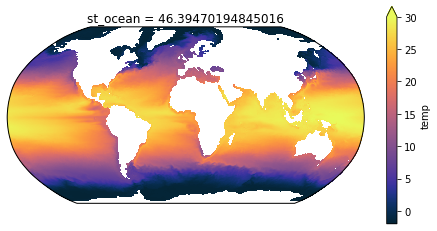

In [22]:
darray = cc.querying.getvar('025deg_jra55v13_iaf_gmredi6', 'temp', session, n=-1)
temp = darray.mean('time').sel(st_ocean=50, method='nearest') - 273.15
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Robinson())
temp.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),x='xt_ocean', y='yt_ocean',cmap=cm.cm.thermal, vmin=-2, vmax=30)
#ax.coastlines()

### 3.2 Distributed computing

Many of our scripts use multiple cores for their calculations, usually via the following . It sets up a local cluster on your node for distributed computation. 

In [24]:
from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:40699 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 202.49 GB


The dashboard link should allow you to access information on how your work is distributed between the cores on your local cluster.

<center><img src="assets/cookbook.png" width=300></center>